In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sklearn.datasets import load_boston
np.random.seed(0)

In [2]:
# load boston housing prices dataset
boston = load_boston()
x = boston['data']
N = x.shape[0]
x = np.concatenate((np.ones((506,1)),x),axis=1) #add constant one feature - no bias needed
d = x.shape[1]
y = boston['target']

idx = np.random.permutation(range(N))

In [3]:
#helper function
def l2(A,B):
    '''
    Input: A is a Nxd matrix
           B is a Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between A[i,:] and B[j,:]
    i.e. dist[i,j] = ||A[i,:]-B[j,:]||^2
    '''
    A_norm = (A**2).sum(axis=1).reshape(A.shape[0],1)
    B_norm = (B**2).sum(axis=1).reshape(1,B.shape[0])
    dist = A_norm+B_norm-2*A.dot(B.transpose())
    return dist

In [4]:
#helper function
def run_on_fold(x_test, y_test, x_train, y_train, taus):
    '''
    Input: x_test is the N_test x d design matrix
           y_test is the N_test x 1 targets vector        
           x_train is the N_train x d design matrix
           y_train is the N_train x 1 targets vector
           taus is a vector of tau values to evaluate
    output: losses a vector of average losses one for each tau value
    '''
    N_test = x_test.shape[0]
    losses = np.zeros(taus.shape)
    for j,tau in enumerate(taus):
        predictions =  np.array([LRLS(x_test[i,:].reshape(1,d),x_train,y_train, tau) \
                        for i in range(N_test)])
        losses[j] = ((predictions-y_test)**2).mean()
    return losses

In [5]:
#to implement
def LRLS(test_datum, x_train, y_train, tau, lam=1e-5):
    '''
    Input: test_datum is a d x 1 test vector ? (from run_on_fold, it should be 1 x d)?
           x_train is the N_train x d design matrix
           y_train is the N_train x 1 targets vector
           tau is the local reweighting parameter
           lam is the regularization parameter
    output is y_hat the prediction on test_datum
    '''
    # test_datum = test_datum.T
    weights = l2(x_train, test_datum)
    weights = - weights / (2 * tau**2)
    weights = np.exp(weights - sp.misc.logsumexp((weights)))
    
    N_train = x_train.shape[0]
    A = np.zeros([N_train, N_train])
    for i in range(N_train):
        A[i, i] = weights[i]
    
    design = x_train.T.dot(A).dot(x_train)
    offset = lam * np.identity(x_train.shape[1])
    predict = x_train.T.dot(A).dot(y_train)
    
    w = np.linalg.solve(design + offset, predict)
    y_hat = test_datum.dot(w)
    return y_hat

In [6]:
def run_k_fold(x, y, taus, k):
    '''
    Input: x is the N x d design matrix
           y is the N x 1 targets vector    
           taus is a vector of tau values to evaluate
           K in the number of folds
    output is losses a vector of k-fold cross validation losses one for each tau value
    '''
    N = x.shape[0]
    stride = N // k
    start = 0
    losses = []
    while start < N:
        end = min(start + stride, N)
        test_indices = idx[start:end]
        train_indices = np.append(idx[0:start], idx[end:N])
        
        x_test = x[test_indices]
        y_test = y[test_indices]
        x_train = x[train_indices]
        y_train = y[train_indices]
        losses.append(run_on_fold(x_test, y_test, x_train, y_train, taus))
        start += stride
    
    losses = np.array(losses)
    return np.mean(losses, axis=0)

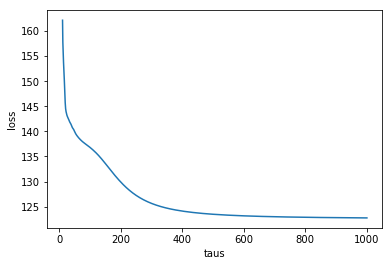

min loss = 122.74883420654332


In [9]:
# In this excersice we fixed lambda (hard coded to 1e-5) and only set tau value. 
# Feel free to play with lambda as well if you wish
taus = np.logspace(1.0,3,200)
losses = run_k_fold(x,y,taus,k=5)
plt.plot(taus, losses)
plt.xlabel('taus')
plt.ylabel('loss')
plt.show()
print("min loss = {}".format(losses.min()))